## Step 1: Define the Problem
We want to analyze and predict the amount of Airline passengers in the future of at least 12 months

## Step 2: Collect and clean the data
From observing the head and tail of the data, and looking at the data statistics, we can see that the data is clean. Just need it in the right data structure. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,4

In [2]:
df = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## Step 3: Explore and visualize the data
Let's use graphical methods to understand the characteristics of the time series (seasonality, trend, autocorrleation)

In [3]:
#We observe no missing values in the data
df.isna().sum()

#Passengers    0
dtype: int64

In [4]:
from datetime import datetime
print(df.head(5))
print(df.tail(5))

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
            #Passengers
Month                  
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432


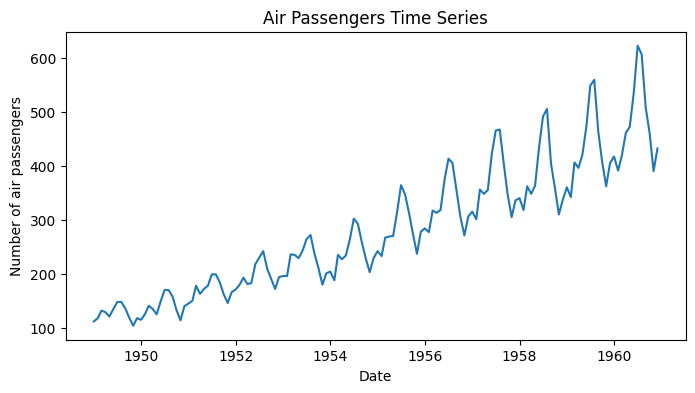

In [5]:
#We observe that the data is not stationary. However, let's do a formal test to confirm this.
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.title('Air Passengers Time Series')
plt.plot(df)

## Step 4: Test for stationarity

We use the Dickey-Fuller test and observe that the p-value is too high (>0.05)

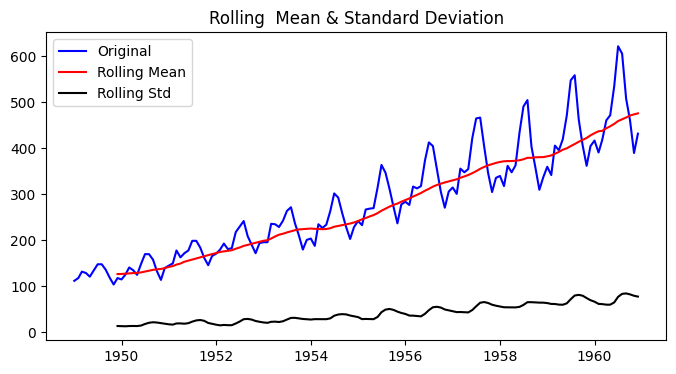

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
#Perform Dickey-Fuller test for stationarity:

from statsmodels.tsa.stattools import adfuller

def adfullerTest(df):
    #Determining rolling statistics
    rolmean = df.rolling(window = 12).mean()
    rolstd = df.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(df, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

adfullerTest(df)

In the rolling statistics above, we can see that even when using a rolling average, the standard deviation still increases over time. The mean (trend) also increases over time, which shows lack of stationarity. the p-value of 0.991880 confirms this.

## Step 5: Make the time series stationary

There are a couple of ways to make a time series stationary: differencing, log transformation, seasonal adjustment, smoothing, and regression modeling. We observe from the graph of our time series that it has a nonconstant mean and variance, and a seasonal component. We can do a decomposition to further understand this.

### 5.1 - Decomposition

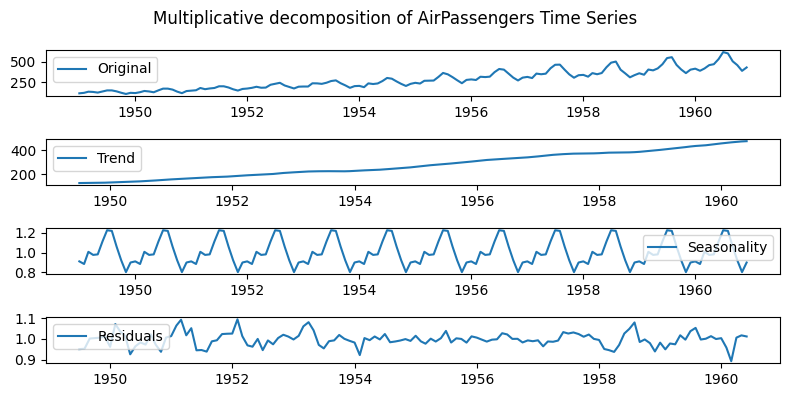

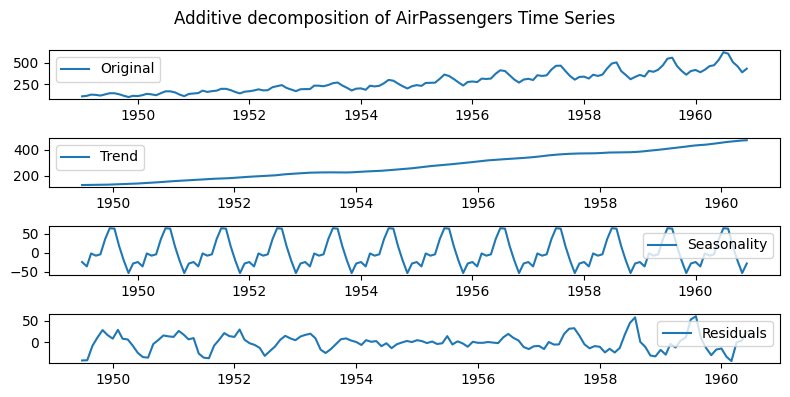

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_mult = seasonal_decompose(df, model='multiplicative')
decomposition_add = seasonal_decompose(df, model='additive')

# let's plot the trend, seasonality and residuals
plt.figure(figsize=(8, 4))
plt.suptitle('Multiplicative decomposition of AirPassengers Time Series')
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend()
plt.subplot(412)
plt.plot(decomposition_mult.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(decomposition_mult.seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(decomposition_mult.resid, label='Residuals')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8, 4))
plt.suptitle('Additive decomposition of AirPassengers Time Series')
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend()
plt.subplot(412)
plt.plot(decomposition_add.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(decomposition_add.seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(decomposition_add.resid, label='Residuals')
plt.legend()
plt.tight_layout()


We can compare the residuals from both decompositions. The multiplicative one looks random while the additive one has greater variance on both ends, with the variance decreasing towards the middle. So, the multiplicative decomposition will be better suited for this series. 

We can look closer at the multiplicative decomposition and see that there is a clear seasonality and trend. So when creating a forecast, we will either need a model that doesn't need stationarity, or make the data stationary, taking into account both seasonality and trend.

In this project, we will create models using the holt-winters exponential smoothing method, and compare it to an ARIMA model using performance metrics (mean absolute error, mean squared error, and root mean squared error). 

### 5.2 - Differencing

We are going to achieve stationarity for the ARIMA model using differencing. In order to stabilize the variance which increases over time, we use a log transformation. In order to detrend the data which had an upward trend over time, we use the first difference. After checking the results of the stationarity test and observing the completely transformed data, we may choose to use additional differentiations if the first difference is not enough. 

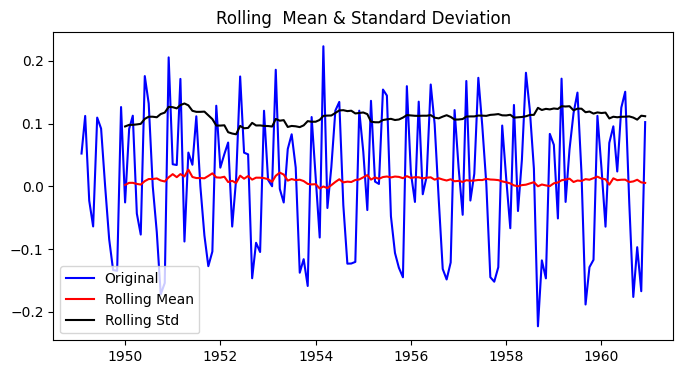

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [8]:
df_log = np.log(df)
df_log_diff = df_log - df_log.shift()
df_log_diff.dropna(inplace=True)

adfullerTest(df_log_diff)
df_log_diff

Mean and standard deviation vary little, and the p-value of 0.07 is close to the 0.05 threshold that we are looking for, but it would be better to achieve a lower p-value to have more confidence in the stationarity of the series. Let's try a second order differencing. 

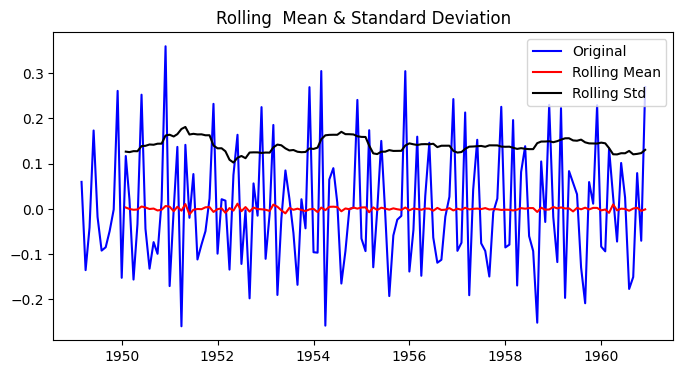

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


,#Passengers
Month,
1949-03-01,0.059932
1949-04-01,-0.135107
1949-05-01,-0.041032
1949-06-01,0.173506
1949-07-01,-0.017547
...,...
1960-08-01,-0.176733
1960-09-01,-0.150338
1960-10-01,0.079315


In [9]:
df_log_diff = df_log - df_log.shift()
df_log_diff2 = df_log_diff - df_log_diff.shift()
df_log_diff2.dropna(inplace=True)

adfullerTest(df_log_diff2)
df_log_diff2

We can observe that the p-value of 7.419305e-13 is well below the threshold of 0.05. We can reject the null hypothesis, and be confident that this series is stationary. 

## Part 6: Create the ARIMA model

The ARIMA model uses parameters p, d, q:
- p: # of auto-regressive terms: 
  The number of terms before the current term that are used to predict the current term
- d: Number of differences:
  The order of the difference (In this case, we already did a second-order differencing and achieved stationarity, so we should expect d to be 0)
- q: # of moving average terms: 
  Like p, but instead each 'term' if the difference between the moving average and that term

The SARIMAX model uses three additional parameters: P, D, Q, s:
- P: # of seasonal auto-regerssive terms
- D: Number of seasonal differences 
- Q: # of seasonal moving average terms
- s: seasonal period length

We also want to split the dataset into training and testing data so we can get the performance metrics to evaluate the model later. 

In [10]:
#Split the data into train and test sets
train_data_log_diff2 = df_log_diff2[:int(0.8*len(df_log_diff2))]
test_data_log_diff2 = df_log_diff2[int(0.8*len(df_log_diff2)):]

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

auto_model = auto_arima(
    train_data_log_diff2,
    seasonal=True,
    m=12,
    suppress_warnings=True,
    stepwise=True,
    trace=True,
)
model = ARIMA(df_log_diff2, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model_log_diff2 = model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-231.715, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-305.007, Time=0.98 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-345.320, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-233.715, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-323.044, Time=0.28 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-341.210, Time=0.74 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-344.656, Time=3.00 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-337.758, Time=0.84 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-343.194, Time=4.41 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-262.577, Time=1.80 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-351.491, Time=2.58 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-331.692, Time=0.50 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-350.455, Time=3.07 sec
 ARIMA(1,0,1)(0,1,2)[12]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Step 7: Create the Holt-Winters Exponential Smoothing model (HWE)

This model takes into account the following components:

- Level (l): the current value of the series
- Trend (b): the general direction of the series
- Seasonality(s): the repeating pattern of the series

In terms of trend and seasonality, we will have to determins whether to use an additive or multiplicative model. 

- Additive: changes are roughly constant throughout
- Multiplicative: changes are roughly in proportion to the series throughout

Noting the decomposition we did earlier, we will use the multiplicative model for both trend and seasonality since the residuals in that model were more random. In addition, we can observe in the original untransformed data that the trend seems to increase non-linearly over time indicating a proportional change. However, it is not so clear that the seasonality is additive or multiplicative upon first glance. 

We will create HWE models with a multiplicative trend, and both additive and multiplicative seasonalities, and compare their performance metrics. 

Just like with the ARIMA model, we first split the data into train and test sets.

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_df = df[:int(0.8*len(df))]
test_df = df[int(0.8*len(df)):]

model_HWE_add = ExponentialSmoothing(train_df, seasonal_periods=12, trend='mul', seasonal='add')
model_HWE_mult = ExponentialSmoothing(train_df, seasonal_periods=12, trend='mul', seasonal='mul')
fit_HWE_add = model_HWE_add.fit()
fit_HWE_mult = model_HWE_mult.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


## Step 8: Evaluate the models

We have three models so far: ARIMA, HWE with additive seasonality, and HWE with multiplicative seasonality. Let's compare them on their Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). 

In [13]:
from sklearn.metrics import mean_squared_error

def eval_model(model, test_data, ARIMA=False, train_data=None):
  # Forecast the test data
  forecast_steps = len(test_data)

  if ARIMA:
    forecast_diff = model.forecast(steps=forecast_steps)

    # Revert the forecasted differences back to the original log scale
    last_train_value_log = np.log(train_data.iloc[-1])[0]
    forecast_log = np.r_[last_train_value_log, np.cumsum(forecast_diff.values)].cumsum()
    forecast_log = pd.Series(forecast_log[1:], index=test_data.index)

    # Exponentiate the log-transformed data to get the forecasts in the original scale
    forecast = np.exp(forecast_log)
  else:
    forecast = model.forecast(steps=forecast_steps)

  # Calculate the performance metrics
  mse = mean_squared_error(test_data, forecast)
  rmse = np.sqrt(mse)
  mape = np.mean(np.abs((test_data.values - forecast.values) / test_data.values)) * 100

  return (mse, rmse, mape)

# Note that we want to compare the forecasted values to the original test data, not the log transformed test data so with the ARIMA model we will input the untransformed test data
eval_set = {'ARIMA': [model_log_diff2, test_df, train_df], 'Holt-Winters Additive': [fit_HWE_add, test_df], 'Holt-Winters Multiplicative': [fit_HWE_mult, test_df]}

eval_results = {}
for model_name, model in eval_set.items():
  if model_name == 'ARIMA':
    eval_results[model_name] = eval_model(model[0], model[1], ARIMA=True, train_data=model[2])
  else:
    eval_results[model_name] = eval_model(model[0], model[1])

eval_results

{'ARIMA': (102428.00270710702, 320.04375123896267, 59.60361456213611),
 'Holt-Winters Additive': (986.1010391213898,
  31.402245765572083,
  17.89332867389561),
 'Holt-Winters Multiplicative': (455.32714496737685,
  21.33839602611632,
  19.79658175849796)}

In [14]:
# Let's print the results more clearly
for model_name, model in eval_results.items():
  print(model_name)
  print("Mean Squared Error:", model[0])
  print("Root Mean Squared Error:", model[1])
  print("Mean Absolute Percentage Error:", model[2], "%")
  print()

ARIMA
Mean Squared Error: 102428.00270710702
Root Mean Squared Error: 320.04375123896267
Mean Absolute Percentage Error: 59.60361456213611 %

Holt-Winters Additive
Mean Squared Error: 986.1010391213898
Root Mean Squared Error: 31.402245765572083
Mean Absolute Percentage Error: 17.89332867389561 %

Holt-Winters Multiplicative
Mean Squared Error: 455.32714496737685
Root Mean Squared Error: 21.33839602611632
Mean Absolute Percentage Error: 19.79658175849796 %



A Lower RMSE is generally better, and an MAPE of 10% is good, while 20% is still acceptable for many applications. The Holt-Winters Multiplicative model had the lowest MSE and RMSE. In the case of the AirPassengers dataset, the number of passengers ranges from around 100 to over 600, and the RMSE of 21 for the Holt-Winters Multiplicative model can be considered an acceptable error in the context of this dataset. While arguements for both the Holt-Winters models can be made due to one's lower RMSE compared to another one's lower MAPE, we will proceed with the multiplicative model. 

 If given more time, we may choose to tune the hyperparameters of the ARIMA model to see if we can get better results, or use a different technique to make the data stationary before modeling. Additionally, we would use other prediction models. 

## Step 9: Forecast 36 months forward

Will will use the HWM model for the forecast.

In [18]:
#Create a model using the entire dataset
model_HWE_mult_fit = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='mul').fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


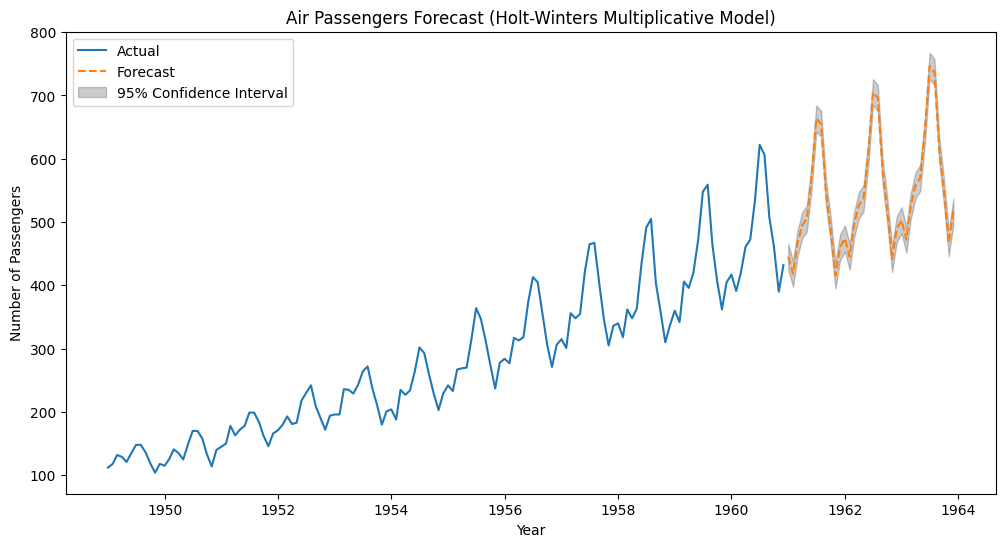

In [19]:
from scipy import stats

# Forecast the next 36 months
forecast_steps = 36
forecast_hwe_mult = model_HWE_mult_fit.forecast(steps=forecast_steps)

# Calculate the residual variance
residual_variance = np.var(model_HWE_mult_fit.resid)

# Create the confidence intervals
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)
conf_int_lower = forecast_hwe_mult - z_score * np.sqrt(residual_variance)
conf_int_upper = forecast_hwe_mult + z_score * np.sqrt(residual_variance)

# Create new DataFrames to store the forecasted values and confidence intervals
forecast_dates = conf_int_lower.index
forecast_df = pd.DataFrame(forecast_hwe_mult, columns=['Forecast'], index=forecast_dates)
conf_int_df = pd.DataFrame({'Lower': conf_int_lower, 'Upper': conf_int_upper}, index=forecast_dates)

# Combine the original data and the forecast data
combined_df = pd.concat([df, forecast_df], axis=1)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(combined_df['#Passengers'], label='Actual')
plt.plot(combined_df['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(conf_int_df.index, conf_int_df['Lower'], conf_int_df['Upper'], color='k', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Forecast (Holt-Winters Multiplicative Model)')
plt.legend()
plt.show()